## Import

In [2]:
import numpy as np
import pickle as pkl
from matplotlib import pyplot as plt

In [172]:
seed_list = [123]#,20260116]
fold_list = [0,1,2,3,4]
outputs = {}
for seed in seed_list:
    for fold in fold_list:
        folder_path = f"output_models/full_lc/seed#{seed}/{fold}-fold"
        outputs[f"seed#{seed}_{fold}-fold"] = pkl.load(open(folder_path + "/model_evals.pkl".format(seed),"rb"))

#### Plot train loss (blue) and validation loss (red) for different seeds (5 in each seed for each loss)

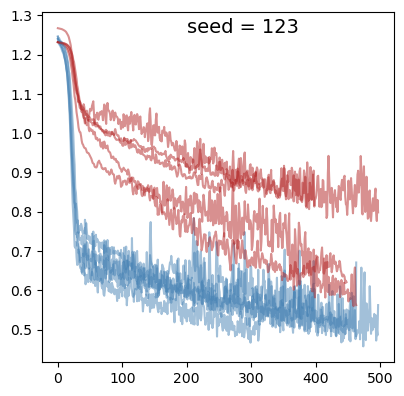

In [173]:
fig = plt.figure(figsize=(10,10))
for ix1, seed in enumerate(seed_list):
    ax = fig.add_subplot(2,2,ix1+1)
    for ix2, fold in enumerate(fold_list):
        output = outputs[f"seed#{seed}_{fold}-fold"]
        min_val_loss_ix = output["val_loss"].argmin()
        ax.plot(output["train_loss"][0:min_val_loss_ix], color='steelblue', alpha=0.5)
        ax.plot(output["val_loss"][0:min_val_loss_ix], color='firebrick', alpha=0.5)
        if ix2 == 0:
            ax.text(s='seed = {}'.format(seed),x=len(output["val_loss"])/2.5,y=max(max(output["train_loss"]),max(output["val_loss"]))/1.01,fontsize=14)

#### Plot TPR (blue) and TNR (red) for different seeds (5 in each seed for each loss)

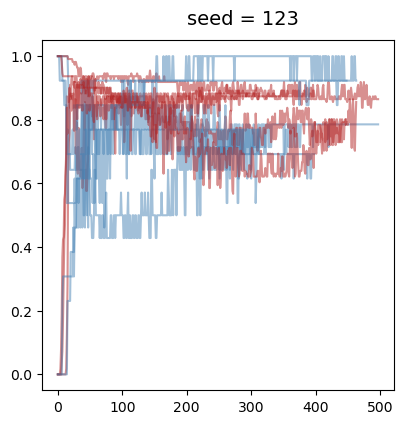

In [174]:
fig = plt.figure(figsize=(10,10))
for ix1, seed in enumerate(seed_list):
    ax = fig.add_subplot(2,2,ix1+1)
    for ix2, fold in enumerate(fold_list):
        output = outputs[f"seed#{seed}_{fold}-fold"]
        min_val_loss_ix = output["val_loss"].argmin()
        tn = output['tn']
        fp = output['fp']
        fn = output['fn']
        tp = output['tp']

        tpr = tp/(tp+fn)
        tnr = tn/(fp+tn)
    
        ax.plot(tpr[0:min_val_loss_ix], color='steelblue', alpha=0.5)
        ax.plot(tnr[0:min_val_loss_ix], color='firebrick', alpha=0.5)
        if ix2 == 0:
            ax.text(s='seed = {}'.format(seed),x=len(output["val_loss"])/2.5,y=1.1,fontsize=14)

#### Plot confusing matrix for the best fold of each seed

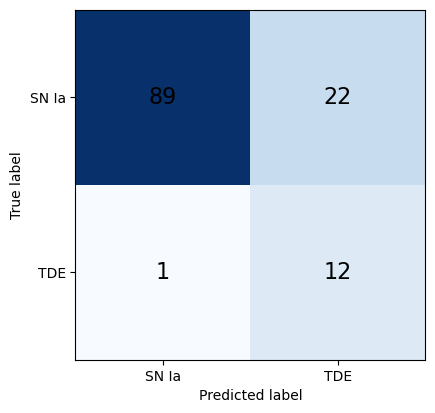

In [175]:
fig = plt.figure(figsize=(10,10))
for ix1, seed in enumerate(seed_list):
    ax = fig.add_subplot(2,2,ix1+1)
    best_val_loss = np.inf
    worst_val_loss = 0.
    for ix2, fold in enumerate(fold_list):
        output = outputs[f"seed#{seed}_{fold}-fold"]
        best_val_loss_ix = output['val_loss'].argmin()
        temp_best_val_loss = output['val_loss'][best_val_loss_ix]
        temp_worst_val_loss = output['val_loss'][best_val_loss_ix]
        if temp_best_val_loss < best_val_loss:
            best_val_loss = temp_best_val_loss
            ix_best_to_plot = ix2
        if temp_worst_val_loss > best_val_loss:
            worst_val_loss = temp_worst_val_loss
            ix_worst_to_plot = ix2
    for ix2, fold in enumerate(fold_list):
        if ix2 == ix_best_to_plot:
            output = outputs[f"seed#{seed}_{fold}-fold"]
            val_loss_ix = output['val_loss'].argmin()
            cm = np.array([
                [output['tn'][best_val_loss_ix], output['fp'][best_val_loss_ix]],   # [TN, FP]
                [output['fn'][best_val_loss_ix],  output['tp'][best_val_loss_ix]]    # [FN, TP]
            ])
            labels = ["SN Ia", "TDE"]
            im = ax.imshow(cm, cmap="Blues")
            
            # Show values on the cells
            for (i, j), val in np.ndenumerate(cm):
                ax.text(j, i, f"{val}", ha="center", va="center", color="black",fontsize=16)
            
            # Axis labels
            ax.set_xticks([0, 1], labels)
            ax.set_yticks([0, 1], labels)
        
            ax.set_xlabel("Predicted label")
            ax.set_ylabel("True label")

In [176]:
best_bal_acc_vec = []
best_TDE_recall = []
best_TDE_prec = []
best_Ia_recall = []
best_Ia_prec = []
for ix1, seed in enumerate(seed_list):
    best_val_loss = np.inf
    for ix2, fold in enumerate(fold_list):
        output = outputs[f"seed#{seed}_{fold}-fold"]
        best_val_loss_ix = output['val_loss'].argmin()
        best_bal_acc_vec.append(output['bal_acc'][best_val_loss_ix])

        best_TDE_recall.append(output['tp'][best_val_loss_ix]/(output['tp'][best_val_loss_ix] + output['fn'][best_val_loss_ix]))
        best_TDE_prec.append(output['tp'][best_val_loss_ix]/(output['tp'][best_val_loss_ix] + output['fp'][best_val_loss_ix]))

        best_Ia_recall.append(output['tn'][best_val_loss_ix]/(output['fp'][best_val_loss_ix] + output['tn'][best_val_loss_ix]))
        best_Ia_prec.append(output['tn'][best_val_loss_ix]/(output['fn'][best_val_loss_ix] + output['tn'][best_val_loss_ix]))
best_bal_acc_vec = np.array(best_bal_acc_vec)
best_TDE_recall = np.array(best_TDE_recall)
best_TDE_prec = np.array(best_TDE_prec)
best_Ia_recall = np.array(best_Ia_recall)
best_Ia_prec = np.array(best_Ia_prec)
F1_TDE = 2.*best_TDE_recall*best_TDE_prec/(best_TDE_recall + best_TDE_prec)
F1_Ia = 2.*best_Ia_recall*best_Ia_prec/(best_Ia_recall + best_Ia_prec)
F1_macro = 0.5*(F1_TDE + F1_Ia)
print(f"Balanced accuracy across seeds and folds = {best_bal_acc_vec.mean():.3f} +/- {best_bal_acc_vec.std():.3f}")
print(f"TDE recall across seeds and folds = {best_TDE_recall.mean():.3f} +/- {best_TDE_recall.std():.3f}")
print(f"TDE precision across seeds and folds = {best_TDE_prec.mean():.3f} +/- {best_TDE_prec.std():.3f}")
print(f"TDE F1 across seeds and folds = {F1_TDE.mean():.3f} +/- {F1_TDE.std():.3f}")
print(f"SN Ia recall across seeds and folds = {best_Ia_recall.mean():.3f} +/- {best_Ia_recall.std():.3f}")
print(f"SN Ia precision across seeds and folds = {best_Ia_prec.mean():.3f} +/- {best_Ia_prec.std():.3f}")
print(f"SN Ia F1 across seeds and folds = {F1_Ia.mean():.3f} +/- {F1_Ia.std():.3f}")
print(f"Macro F1 across seeds and folds = {F1_macro.mean():.3f} +/- {F1_macro.std():.3f}")

Balanced accuracy across seeds and folds = 0.844 +/- 0.016
TDE recall across seeds and folds = 0.848 +/- 0.049
TDE precision across seeds and folds = 0.390 +/- 0.035
TDE F1 across seeds and folds = 0.532 +/- 0.029
SN Ia recall across seeds and folds = 0.840 +/- 0.028
SN Ia precision across seeds and folds = 0.979 +/- 0.006
SN Ia F1 across seeds and folds = 0.904 +/- 0.015
Macro F1 across seeds and folds = 0.718 +/- 0.021


In [171]:
best_bal_acc_vec = []
best_TDE_recall = []
best_TDE_prec = []
best_Ia_recall = []
best_Ia_prec = []
for ix1, seed in enumerate(seed_list):
    best_val_loss = np.inf
    worst_val_loss = 0.
    for ix2, fold in enumerate(fold_list):
        output = outputs[f"seed#{seed}_{fold}-fold"]
        best_val_loss_ix = output['val_loss'].argmin()
        temp_best_val_loss = output['val_loss'][best_val_loss_ix]
        temp_worst_val_loss = output['val_loss'][best_val_loss_ix]
        if temp_best_val_loss < best_val_loss:
            best_val_loss = temp_best_val_loss
            ix_best_to_plot = ix2
        if temp_worst_val_loss > best_val_loss:
            worst_val_loss = temp_worst_val_loss
            ix_worst_to_plot = ix2
    for ix2, fold in enumerate(fold_list):
        if ix2 == ix_best_to_plot:
            output = outputs[f"seed#{seed}_{fold}-fold"]
            best_val_loss_ix = output['val_loss'].argmin()
            best_bal_acc_vec.append(output['bal_acc'][best_val_loss_ix])

            best_TDE_recall.append(output['tp'][best_val_loss_ix]/(output['tp'][best_val_loss_ix] + output['fn'][best_val_loss_ix]))
            best_TDE_prec.append(output['tp'][best_val_loss_ix]/(output['tp'][best_val_loss_ix] + output['fp'][best_val_loss_ix]))

            best_Ia_recall.append(output['tn'][best_val_loss_ix]/(output['fp'][best_val_loss_ix] + output['tn'][best_val_loss_ix]))
            best_Ia_prec.append(output['tn'][best_val_loss_ix]/(output['fn'][best_val_loss_ix] + output['tn'][best_val_loss_ix]))
best_bal_acc_vec = np.array(best_bal_acc_vec)
best_TDE_recall = np.array(best_TDE_recall)
best_TDE_prec = np.array(best_TDE_prec)
best_Ia_recall = np.array(best_Ia_recall)
best_Ia_prec = np.array(best_Ia_prec)
F1_TDE = 2.*best_TDE_recall*best_TDE_prec/(best_TDE_recall + best_TDE_prec)
F1_Ia = 2.*best_Ia_recall*best_Ia_prec/(best_Ia_recall + best_Ia_prec)
F1_macro = 0.5*(F1_TDE + F1_Ia)
print(f"Balanced accuracy across seeds and folds = {best_bal_acc_vec.mean():.3f} +/- {best_bal_acc_vec.std():.3f}")
print(f"TDE recall across seeds and folds = {best_TDE_recall.mean():.3f} +/- {best_TDE_recall.std():.3f}")
print(f"TDE precision across seeds and folds = {best_TDE_prec.mean():.3f} +/- {best_TDE_prec.std():.3f}")
print(f"TDE F1 across seeds and folds = {F1_TDE.mean():.3f} +/- {F1_TDE.std():.3f}")
print(f"SN Ia recall across seeds and folds = {best_Ia_recall.mean():.3f} +/- {best_Ia_recall.std():.3f}")
print(f"SN Ia precision across seeds and folds = {best_Ia_prec.mean():.3f} +/- {best_Ia_prec.std():.3f}")
print(f"SN Ia F1 across seeds and folds = {F1_Ia.mean():.3f} +/- {F1_Ia.std():.3f}")
print(f"Macro F1 across seeds and folds = {F1_macro.mean():.3f} +/- {F1_macro.std():.3f}")

Balanced accuracy across seeds and folds = 0.869 +/- 0.000
TDE recall across seeds and folds = 0.846 +/- 0.000
TDE precision across seeds and folds = 0.478 +/- 0.000
TDE F1 across seeds and folds = 0.611 +/- 0.000
SN Ia recall across seeds and folds = 0.892 +/- 0.000
SN Ia precision across seeds and folds = 0.980 +/- 0.000
SN Ia F1 across seeds and folds = 0.934 +/- 0.000
Macro F1 across seeds and folds = 0.773 +/- 0.000
